In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#option flags
debug_mode = True

In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_16_22_day.csv")

In [4]:
df = pd.read_csv(filename)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600068.SH,20210901,9.50,10.13,9.35,9.93,9.35,0.58,6.2032,2251228.82,2202662.358
1,600068.SH,20210831,9.30,9.36,9.20,9.35,9.27,0.08,0.8630,860898.54,798131.416
2,600068.SH,20210830,9.28,9.60,9.24,9.27,9.23,0.04,0.4334,1196573.17,1120718.973
3,600068.SH,20210827,9.20,9.32,9.14,9.23,9.20,0.03,0.3261,740285.00,682613.418
4,600068.SH,20210826,9.40,9.68,9.09,9.20,9.30,-0.10,-1.0753,1558044.39,1453379.421
...,...,...,...,...,...,...,...,...,...,...,...
831628,600005.SH,20160108,3.42,3.63,3.40,3.63,3.30,0.33,10.0000,2623620.41,940783.297
831629,600005.SH,20160107,3.65,3.65,3.29,3.30,3.66,-0.36,-9.8400,433545.00,151466.196
831630,600005.SH,20160106,3.33,3.66,3.30,3.66,3.33,0.33,9.9100,2065794.86,739556.288
831631,600005.SH,20160105,3.18,3.41,3.14,3.33,3.23,0.10,3.1000,751018.19,247455.594


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,8.316330e+05,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,8.316330e+05,8.316330e+05
mean,2.019075e+07,30.046193,30.684832,29.469071,30.083063,30.062344,0.020719,0.049269,3.619721e+05,5.182667e+05
std,1.904651e+04,74.789339,76.308630,73.401426,74.899948,74.831898,2.434816,2.773921,7.258554e+05,9.041153e+05
min,2.016010e+07,0.170000,0.180000,0.160000,0.170000,0.170000,-209.990000,-36.877100,5.000000e+00,5.544000e+00
25%,2.017112e+07,6.560000,6.660000,6.460000,6.560000,6.560000,-0.150000,-1.200000,7.226044e+04,1.038375e+05
50%,2.019080e+07,13.200000,13.430000,13.000000,13.210000,13.210000,0.000000,0.000000,1.682014e+05,2.331566e+05
75%,2.021022e+07,28.120000,28.680000,27.660000,28.160000,28.150000,0.140000,1.143800,3.849387e+05,5.462001e+05
max,2.022082e+07,2587.980000,2627.880000,2485.000000,2601.000000,2601.000000,228.980000,306.108600,4.114453e+07,4.796717e+07


# Model DataFrame preprocessing

In [7]:
#split data into different stock
stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]
#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


In [8]:
''' alternative code for split stock according to ts_code
out = []

for ts_code in list(set(list(df['ts_code']))):
    out.append(df[df['ts_code']==ts_code])
'''

" alternative code for split stock according to ts_code\nout = []\n\nfor ts_code in list(set(list(df['ts_code']))):\n    out.append(df[df['ts_code']==ts_code])\n"

In [9]:
''' check data integrity
for stock in stock_list:
    if len(stock) < 500:
        print(stock)
'''

' check data integrity\nfor stock in stock_list:\n    if len(stock) < 500:\n        print(stock)\n'

In [11]:
stock_list[0][0:15]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
304518,000001.SZ,20160104,12.00,12.03,11.23,11.33,11.99,-0.66,-5.50,563497.87,660376.1531
304517,000001.SZ,20160105,11.27,11.57,11.15,11.40,11.33,0.07,0.62,663269.95,755531.3537
304516,000001.SZ,20160106,11.42,11.56,11.39,11.53,11.40,0.13,1.14,515706.44,591698.5204
304515,000001.SZ,20160107,11.41,11.41,10.91,10.94,11.53,-0.59,-5.12,174761.10,194869.4935
304514,000001.SZ,20160108,11.21,11.29,10.90,11.12,10.94,0.18,1.65,747527.58,831334.5462
304513,000001.SZ,20160111,11.00,11.08,10.68,10.76,11.12,-0.36,-3.24,732013.99,800683.6410
304512,000001.SZ,20160112,10.83,10.91,10.64,10.81,10.76,0.05,0.46,561642.30,605970.8370
304511,000001.SZ,20160113,10.89,10.94,10.70,10.71,10.81,-0.10,-0.93,391709.48,424371.6977
304510,000001.SZ,20160114,10.59,10.80,10.48,10.77,10.71,0.06,0.56,666314.54,708535.0047
304509,000001.SZ,20160115,10.66,10.80,10.42,10.46,10.77,-0.31,-2.88,448202.14,474908.1420


In [10]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [11]:
if debug_mode:
    print(date_time_db[0])

304518   2016-01-04
304517   2016-01-05
304516   2016-01-06
304515   2016-01-07
304514   2016-01-08
            ...    
302905   2022-08-19
302904   2022-08-22
302903   2022-08-23
302902   2022-08-24
302901   2022-08-25
Name: trade_date, Length: 1618, dtype: datetime64[ns]


In [12]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [13]:
if debug_mode:
    date_time_stamp_db[0]

In [14]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

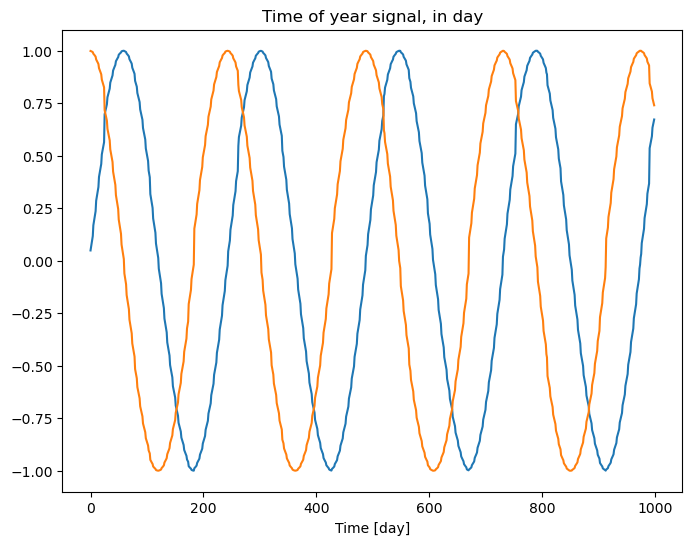

In [15]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [16]:
#stock_list[0].head()

In [17]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    stock.pop("pre_close") #pop previous day close price

In [18]:
if debug_mode:
    stock_list[0].head()

In [19]:
stock_list[0].head()

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.50,563497.87,660376.1531,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.62,663269.95,755531.3537,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.14,515706.44,591698.5204,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.12,174761.10,194869.4935,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.65,747527.58,831334.5462,0.117481,0.993075


# Split Data for training and Validation (Individual Stock Model)

In [19]:
#pick the stock number, for individual model
stock_pick_index = 0

chosen_stock = stock_list[stock_pick_index]

In [20]:
#should be a constant
column_indices = {name: i for i, name in enumerate(chosen_stock.columns)}


In [21]:



n = len(chosen_stock)
num_features = chosen_stock.shape[1]
num_row = chosen_stock.shape[0]


#split training, cross val and testing data
#note since this is a time series data, the split is fixed. No randomization
#no testing data, only cross val data



train_data_p = 0.8  #percentage of train data
val_data_p = 0.1



train_df = chosen_stock[ 0 : int(n * train_data_p) ]
val_df = chosen_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
test_df = chosen_stock[int( n * (train_data_p + val_data_p)) : ]


if debug_mode :
    print("df instances : ", num_row)
    print("df features : ", num_features)
    display(chosen_stock)

df instances :  1618
df features :  10


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.5000,563497.87,6.603762e+05,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.6200,663269.95,7.555314e+05,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.1400,515706.44,5.916985e+05,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.1200,174761.10,1.948695e+05,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.6500,747527.58,8.313345e+05,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
302905,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937
302904,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252
302903,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972
302902,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506


In [22]:
if debug_mode : 
    print("train_df instances : ", len(train_df))
    display(train_df)
    
    for i in range(4): print()
        
    print("val_df instances : ", len(val_df))
    display(val_df)
    
    for i in range(4): print()
    print("val_df instances : ", len(test_df))
    display(test_df)

train_df instances :  1294


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.5000,563497.87,6.603762e+05,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.6200,663269.95,7.555314e+05,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.1400,515706.44,5.916985e+05,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.1200,174761.10,1.948695e+05,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.6500,747527.58,8.313345e+05,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
303229,22.30,23.19,22.29,23.01,1.32,6.0858,1597099.65,3.644578e+06,0.945265,-0.326303
303228,23.19,23.23,22.78,22.98,-0.03,-0.1304,829693.88,1.905209e+06,0.939512,-0.342515
303227,23.32,23.65,23.07,23.29,0.31,1.3490,823230.15,1.920414e+06,0.933481,-0.358626
303226,23.87,24.23,22.90,22.94,-0.35,-1.5028,872417.67,2.037110e+06,0.913739,-0.406302






val_df instances :  162


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
303224,23.29,23.45,22.78,23.35,0.41,1.7873,593837.93,1375141.409,0.899222,-0.437493
303223,23.34,23.71,23.11,23.59,0.24,1.0278,614836.88,1439823.965,0.891563,-0.452897
303222,23.35,23.49,23.01,23.29,-0.30,-1.2717,561981.32,1308177.202,0.883640,-0.468167
303221,23.10,23.70,23.10,23.50,0.21,0.9017,500295.22,1174181.608,0.830700,-0.556720
303220,23.67,24.30,23.39,24.05,0.55,2.3404,802214.21,1929112.374,0.821001,-0.570927
...,...,...,...,...,...,...,...,...,...,...
303067,17.56,17.65,17.45,17.52,-0.05,-0.2846,746435.20,1309029.268,-0.198399,0.980121
303066,17.49,17.71,17.48,17.59,0.07,0.3995,893734.04,1572895.581,-0.181510,0.983389
303065,17.62,17.64,17.30,17.39,-0.20,-1.1370,976927.75,1701772.583,-0.164567,0.986366
303064,17.40,17.43,17.21,17.32,-0.07,-0.4025,1059575.94,1831122.716,-0.147575,0.989051






val_df instances :  162


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
303062,17.33,17.35,17.16,17.22,-0.09,-0.5199,731118.99,1260455.319,-0.079222,0.996857
303061,17.22,17.33,17.09,17.17,-0.05,-0.2904,1126638.91,1934461.075,-0.062062,0.998072
303060,17.16,17.16,16.70,16.75,-0.42,-2.4461,1469373.98,2480534.592,-0.044884,0.998992
303059,16.76,16.95,16.72,16.82,0.07,0.4179,796663.60,1342374.249,-0.027693,0.999616
303058,16.86,16.90,16.40,16.48,-0.34,-2.0214,1750760.89,2899617.148,-0.010494,0.999945
...,...,...,...,...,...,...,...,...,...,...
302905,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2653471.090,-0.732342,-0.680937
302904,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1423361.879,-0.766493,-0.642252
302903,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1137300.431,-0.777428,-0.628972
302902,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1613309.589,-0.788133,-0.615506


In [23]:
#normalize data
train_mean = train_df.mean()
train_std = train_df.std()

#compute the z score to normalize data between features
train_df = (train_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

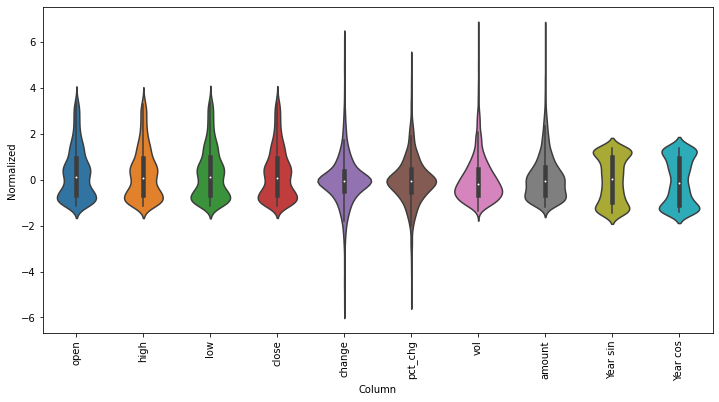

In [24]:
#visuliazation
if debug_mode:
    df_std = (chosen_stock - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(chosen_stock.keys(), rotation=90)

# Time series data window

In [25]:
class time_window_generator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [26]:
    def split_window(self, features):
        
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack( [labels[:, :, self.column_indices[name]] for name in self.label_columns] , axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    time_window_generator.split_window = split_window

In [27]:
    model_batch_size = 6  #the batch size, program use mini batch training method
    
    
    #make dataset use tensorflow's built in function to convert df to a tensorflow dataset for time series.
    #the input shape of the lstm is determined by this
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=model_batch_size,) #batch size

        ds = ds.map(self.split_window)

        return ds

    time_window_generator.make_dataset = make_dataset

In [28]:
    def plot(self, model=None, plot_col='open', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')


    time_window_generator.plot = plot

In [29]:
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        
        result = getattr(self, '_example', None)
        
        if result is None:
            
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        
        return result

    time_window_generator.train = train
    time_window_generator.val = val
    time_window_generator.test = test
    time_window_generator.example = example

In [30]:
def window_inspection(t_window, mode, label=['open']):
    if mode == True:
        
        for i in label:
            t_window.plot(plot_col = i)
        
        print(t_window.train.element_spec)
        
        for example_inputs, example_labels in t_window.train.take(1):
            print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
            print(f'Labels shape (batch, time, features): {example_labels.shape}')

# Window generation

In [31]:
#input time_step = 7 days / timesteps,  output timestep = 1
labels = ['open']

win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, label_columns = labels )
win_7

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (6, 6, 10)
Labels shape (batch, time, features): (6, 1, 1)


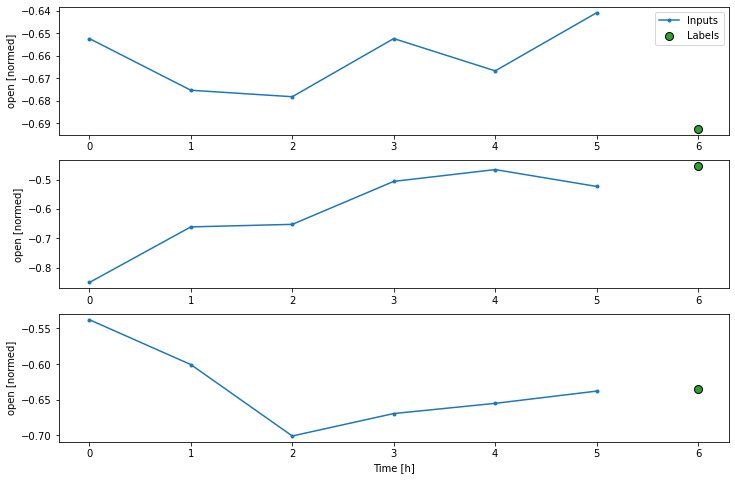

In [32]:
window_inspection(win_7, debug_mode, label = labels)

# Model Functions Area

In [33]:
MAX_EPOCHS = 20
early_stop_patience = 4
#set batch size in make

def compile_and_fit(model, window, patience=early_stop_patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    model.summary()
    
    return history

# Model Area

In [34]:
stacked_lstm_1 = Sequential(

    [

        LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1"

)

In [35]:
#single model, for testing only
train_target = win_7
train_model = stacked_lstm_1

In [36]:
data_stacked_lstm_stock_1 = compile_and_fit(train_model, train_target)

Epoch 1/20
215/215 [==============================] - 8s 16ms/step - loss: 0.6354 - mean_absolute_percentage_error: 69.3564 - val_loss: 0.3845 - val_mean_absolute_percentage_error: 10.9166
Epoch 2/20
215/215 [==============================] - 3s 12ms/step - loss: 0.1760 - mean_absolute_percentage_error: 44.8761 - val_loss: 0.1772 - val_mean_absolute_percentage_error: 7.8584
Epoch 3/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0953 - mean_absolute_percentage_error: 44.5847 - val_loss: 0.1090 - val_mean_absolute_percentage_error: 6.7752
Epoch 4/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0635 - mean_absolute_percentage_error: 39.3209 - val_loss: 0.1316 - val_mean_absolute_percentage_error: 9.2955
Epoch 5/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0483 - mean_absolute_percentage_error: 38.0221 - val_loss: 0.0719 - val_mean_absolute_percentage_error: 7.3113
Epoch 6/20
215/215 [==============================] - 3s 12

In [37]:
print("Model for chosen stock : ", chosen_stock.name)

Model for chosen stock :  000001.SZ


In [38]:
train_model.evaluate(train_target.val)
train_model.evaluate(train_target.test)

26/26 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_absolute_percentage_error: 24.5072


[0.01310996524989605, 24.50716781616211]

# Recursive training testing (Single Stock)

In [39]:
recur_testing = True

In [40]:
if recur_testing:
    
    recur_train_target = win_7
    recur_train_model = stacked_lstm_1

    iteration = 10 #numbers of training iteration
    
    recur_performance = []

    for i in range(iteration):

        compile_and_fit(recur_train_model, recur_train_target)
        recur_performance.append([train_model.evaluate(recur_train_target.val), train_model.evaluate(recur_train_target.test)])
    

Epoch 1/20
215/215 [==============================] - 7s 17ms/step - loss: 0.0175 - mean_absolute_percentage_error: 27.0490 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 3.9110
Epoch 2/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0196 - mean_absolute_percentage_error: 35.7025 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 4.5091
Epoch 3/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0160 - mean_absolute_percentage_error: 26.5303 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 6.4957
Epoch 4/20
215/215 [==============================] - 3s 13ms/step - loss: 0.0158 - mean_absolute_percentage_error: 26.6579 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 4.7987
Epoch 5/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0158 - mean_absolute_percentage_error: 27.8578 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 5.5285
Epoch 6/20
215/215 [==============================] - 3s 13m

In [41]:
print("recursive training performance")

recursive training performance


In [42]:
for i in range(len(recur_performance)):
    print("Iteration : ", i)
    print("MAPE of val data set : ", recur_performance[i][0][1])
    print("MAPE of test data set : ", recur_performance[i][1][1])
    print()

Iteration :  0
MAPE of val data set :  4.624270915985107
MAPE of test data set :  26.01753807067871

Iteration :  1
MAPE of val data set :  7.801743030548096
MAPE of test data set :  27.412025451660156

Iteration :  2
MAPE of val data set :  6.949947834014893
MAPE of test data set :  54.79633712768555

Iteration :  3
MAPE of val data set :  5.4490461349487305
MAPE of test data set :  23.83700942993164

Iteration :  4
MAPE of val data set :  7.433089733123779
MAPE of test data set :  14.27702808380127

Iteration :  5
MAPE of val data set :  8.923831939697266
MAPE of test data set :  33.25187301635742

Iteration :  6
MAPE of val data set :  4.61924409866333
MAPE of test data set :  17.71232795715332

Iteration :  7
MAPE of val data set :  3.9222497940063477
MAPE of test data set :  14.518056869506836

Iteration :  8
MAPE of val data set :  4.034285545349121
MAPE of test data set :  46.01093292236328

Iteration :  9
MAPE of val data set :  3.58642315864563
MAPE of test data set :  13.2890

# Overall Stock Model Training